# Remove disconnected puddle from bathymetry

Issue cells: y= 219, 220, x=706

```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 272829 |ssh| max   20.01     at i j    707 221     MPI rank 160
 kt 272829 |U|   max   1.118     at i j k  308 451   1 MPI rank 741
 kt 272829 Sal   min  1.3292E-03 at i j k  707 221   4 MPI rank 160
 kt 272829 Sal   max   34.93     at i j k  178 452 110 MPI rank 736
```

Essentially a couple of mostly-isolated single cell puddles. Cell y=219 seems more connected, so leave as is for now.

These cells are at the edge of a small island and in a partially iceshelf covered region, so that's how it ended up being open ocean. Probably best to just fill it as land

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean

In [48]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
ds_dom  = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20240305.nc')
ds_mesh = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20240305.nc')

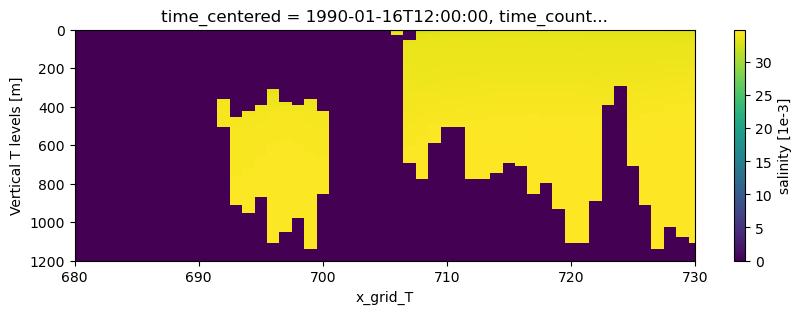

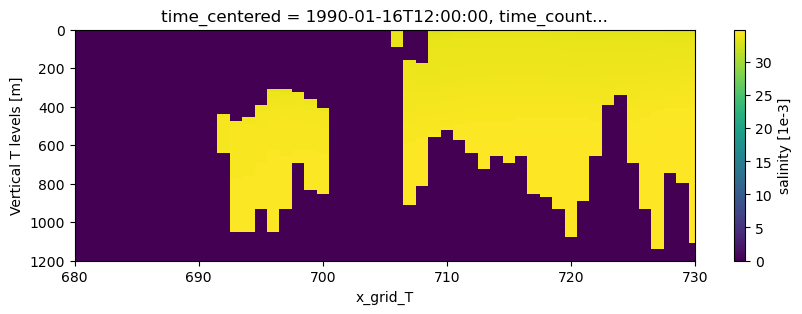

In [36]:
dsT = xr.open_dataset(f'{base_dir}output/CESM2_hist9/files0/eANT025.L121_1m_19900101_19901231_grid_T.nc')

dsT.so.isel(time_counter=0, y_grid_T=220).plot(ylim=(1200, 0), xlim=(680,730), figsize=(10,3))
dsT.so.isel(time_counter=0, y_grid_T=219).plot(ylim=(1200, 0), xlim=(680,730), figsize=(10,3))

In [57]:
def fill_problem_iceshelf(array, dim='2D'):
    # make problem iceshelf land...
    if dim=='2D':
        array[0, 219, 706] = 0
        array[0, 220, 706] = 0
    elif dim=='3D':
        array[0, :, 219, 706] = 0
        array[0, :, 220, 706] = 0
    else:
        raise Exception('Only set up for dimension 2D or 3D')

    return array

In [51]:
ds_dom['top_level'].values[0,219,706]

1

In [59]:
# ---- Domain config file ------------
domcfg_new   = ds_dom.copy()
for var in ['bottom_level', 'bathy_metry', 'isf_draft', 'top_level']:
    new_array       = fill_problem_iceshelf(ds_dom[var].values, dim='2D')
    domcfg_new[var] = (('time_counter', 'y', 'x'), new_array)

domcfg_new.to_netcdf(f'{base_dir}bathymetry/domain_cfg-20250217.nc', unlimited_dims=['time_counter'])

# ---- Mesh mask file ------------
meshmask_new = ds_mesh.copy()
for var in ['bathy_metry', 'mbathy', 'misf', 'mhw', 'hw', 'tmaskutil', 'umaskutil', 'vmaskutil']:
    new_array         = fill_problem_iceshelf(ds_mesh[var].values, dim='2D')
    meshmask_new[var] = (('time_counter', 'y', 'x'), new_array)

for var in ['tmask', 'umask', 'vmask', 'fmask']:
    new_array         = fill_problem_iceshelf(ds_mesh[var].values, dim='3D')
    meshmask_new[var] = (('time_counter', 'nav_lev', 'y', 'x'), new_array)

meshmask_new.to_netcdf(f'{base_dir}bathymetry/mesh_mask-20250217.nc', unlimited_dims=['time_counter'])

In [60]:
ds_dom_new  = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20250217.nc')
ds_mesh_new = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250217.nc')

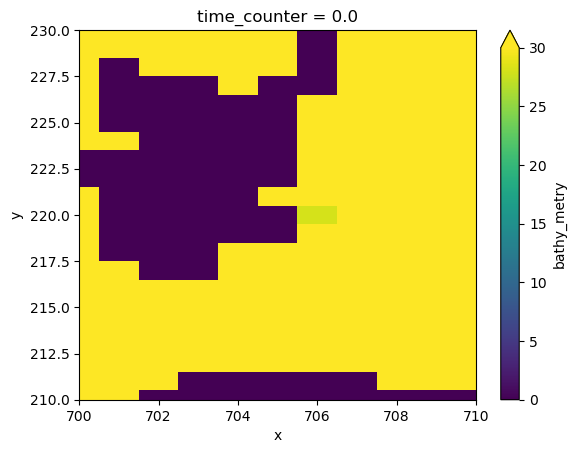

In [54]:
ds_dom['bathy_metry'].isel(time_counter=0).plot(ylim=(210, 230), xlim=(700,710), vmin=0, vmax=30)

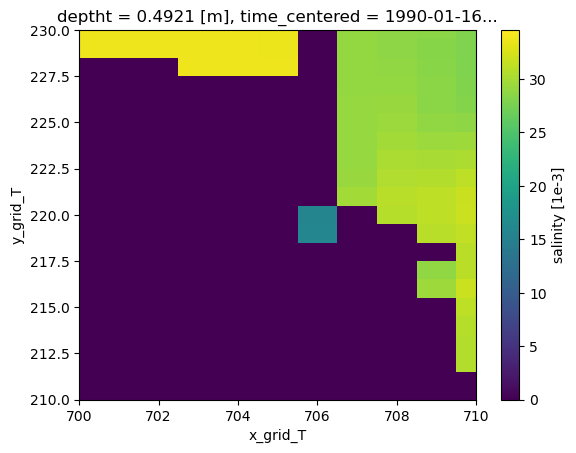

In [52]:
dsT.so.isel(time_counter=0, deptht=0).plot(ylim=(210, 230), xlim=(700,710))

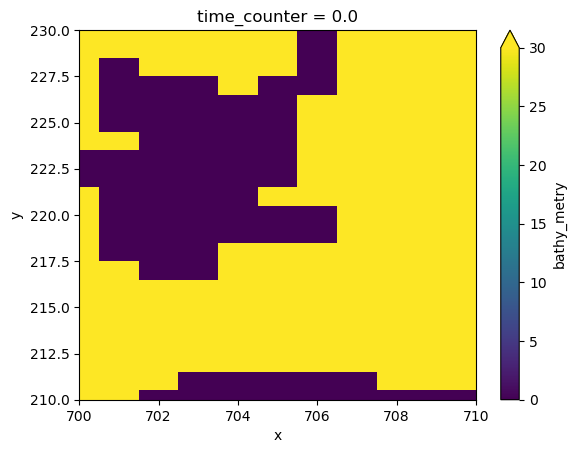

In [61]:
ds_dom_new['bathy_metry'].isel(time_counter=0).plot(ylim=(210, 230), xlim=(700,710), vmin=0, vmax=30)